## z_grid_breathing
Deal with variable vertical grid in NEMO (z-formulation, partial step but full step should work as well)

This notebooks contain a few tests highlighting the properties of NEMO vertical grid, then function definition and tests for correction of the fields accounting for their actual depth with sole knowledge of vertical grid at rest and SSH.

Resulting routines are in gridop.py

In [1]:
%load_ext memory_profiler
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
#from glob import glob
from pathlib import Path
import os

import numpy as np
import xarray as xr
from xgcm import Grid
from xorca.lib import load_xorca_dataset

In [2]:
from dask.distributed import Client, LocalCluster, wait
# Start a local cluster with 4 single-threaded (HDF is triggering errors
# if they are multi-threaded) workers which get only 1500 MiB of memory each.
cluster = LocalCluster(n_workers=2, threads_per_worker=1, memory_limit=1500e6,
                       silence_logs=50)
client = Client(address=cluster)
client

Client Scheduler: tcp://127.0.0.1:58918 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 2.79 GiB


## Load data

In [3]:
data_path = Path("/Users/nlahaye/tmp/eNATL60")

data_fname = "eNATL60NOE-BLBT02_y2009m07d0?.1h_vo*_0-botm.nc"
ssh_fname = "eNATL60NOE-BLBT02_y2009m07we1.1h_ssh.nc"
grid_fname = "m*_eNATL60NOE_3.6.nc"
topo_fname = 'eNATL60NOE_BATHY_GEBCO_2014_2D_msk_v3.1_lb.nc4'

data_files = list(data_path.glob(data_fname))+[data_path/ssh_fname]
grid_files = list(data_path.glob(grid_fname))

In [4]:
%%time
%%memit
ds_tot = load_xorca_dataset(data_files=data_files, aux_files=grid_files,
                              decode_cf=True, model_config="nest"
                             )
# add topo // that is not the actual depth of first masked w level
ds_bot = xr.open_dataset(data_path/topo_fname)
ds_tot = ds_tot.assign_coords(topo = ds_bot.Bathymetry.rename({"x":"x_c", "y":"y_c"}))
# this is the actual bottom depth (positive)
ds_tot = ds_tot.assign_coords(hbot = ds_tot.e3t.where(ds_tot.tmask).sum("z_c"))
print("dataset is {:.1f} GB".format(ds_tot.nbytes/1e9))

dataset is 7.0 GB
peak memory: 204.10 MiB, increment: 68.13 MiB
CPU times: user 3.05 s, sys: 155 ms, total: 3.2 s
Wall time: 7.59 s


In [5]:
ds_tot

<xarray.Dataset>
Dimensions:   (t: 168, x_c: 121, x_r: 121, y_c: 139, y_r: 139, z_c: 300, z_l: 300)
Coordinates: (12/35)
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 ... 132 133 134 135 136 137 138 139
  * y_r       (y_r) float64 1.5 2.5 3.5 4.5 5.5 ... 136.5 137.5 138.5 139.5
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 9 ... 114 115 116 117 118 119 120 121
  * x_r       (x_r) float64 1.5 2.5 3.5 4.5 5.5 ... 118.5 119.5 120.5 121.5
    ...        ...
    tmask     (z_c, y_c, x_c) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    umask     (z_c, y_c, x_r) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    vmask     (z_c, y_r, x_c) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    fmask     (z_c, y_r, x_r) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    topo      (y_c, x_c) float32 4.595e+03 4.604e+03 ... 4.176e+03 4.07e+03
    hbot      (y_c, x_c) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>
Data variables:
    sossheig  (t, y_c, x_c) float32 dask.array<chunksize=(1, 139, 121), meta=np.ndarray>
    vosaline  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>
    votemper  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>

In [6]:
### create xgcm grid
metrics = { ("X",): ["e1t", "e1u", "e1v", "e1f"], 
            ("Y",): ["e2t", "e2u", "e3v", "e2f"],
            ("Z",): ["e3t", "e3w"]}
grid = Grid(ds_tot, metrics=metrics, periodic=False)
grid

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   y_c --> right
  * right    y_r --> center
Z Axis (not periodic, boundary=None):
  * center   z_c --> left
  * left     z_l --> center
X Axis (not periodic, boundary=None):
  * center   x_c --> right
  * right    x_r --> center

### Load base grid and moving grid
Warning: need to rename some dimensions

In [7]:
### Grid at rest. Keep "z" dim as is, because it is both on T and W levels
ds_gro = xr.open_dataset(data_path/grid_fname.replace("*","esh_zgr")).squeeze()

ds_gro = ds_gro.get(["e3t_0", "e3t_1d", "e3w_0", "e3w_1d", "gdept_0", 
                     "gdept_1d", "gdepw_0", "gdepw_1d", "mbathy", "nav_lat", "nav_lon", "nav_lev"])\
            .rename({"x":"x_c", "y":"y_c"})
ds_gro

<xarray.Dataset>
Dimensions:   (x_c: 121, y_c: 139, z: 300)
Dimensions without coordinates: x_c, y_c, z
Data variables:
    e3t_0     (z, y_c, x_c) float64 ...
    e3t_1d    (z) float64 ...
    e3w_0     (z, y_c, x_c) float64 ...
    e3w_1d    (z) float64 ...
    gdept_0   (z, y_c, x_c) float32 ...
    gdept_1d  (z) float64 ...
    gdepw_0   (z, y_c, x_c) float32 ...
    gdepw_1d  (z) float64 ...
    mbathy    (y_c, x_c) int16 ...
    nav_lat   (y_c, x_c) float32 ...
    nav_lon   (y_c, x_c) float32 ...
    nav_lev   (z) float32 ...
Attributes:
    file_name:  mesh_zgr.nc
    TimeStamp:  13/07/2018 22:34:23 +0200
    history:    Tue Apr 13 16:11:09 2021: ncks -O -F -d x,4014,4134 -d y,1438...
    NCO:        4.4.6

In [8]:
### Moving grid. Rename all dimensions (only e3t available)
ds_grd = xr.open_mfdataset(list(data_path.glob(data_fname.replace("vo*","e3t"))))\
            .rename({"time_counter":"t", "deptht":"depth_c", "y":"y_c", "x":"x_c"})\
            .drop_vars(["deptht_bounds", "time_counter_bounds"])
ds_grd = ds_grd.assign_coords(z_c=0*ds_grd.depth_c.astype(int)+np.arange(1,ds_grd.depth_c.size+1))\
            .swap_dims({"depth_c":"z_c"})

ds_grd

<xarray.Dataset>
Dimensions:        (t: 168, x_c: 121, y_c: 139, z_c: 300)
Coordinates:
    depth_c        (z_c) float32 0.4805 1.559 2.794 ... 5.975e+03 6.025e+03
    nav_lat        (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    nav_lon        (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    time_centered  (t) datetime64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
  * t              (t) datetime64[ns] 2009-07-01T00:30:00 ... 2009-07-07T23:3...
  * z_c            (z_c) int64 1 2 3 4 5 6 7 8 ... 294 295 296 297 298 299 300
Dimensions without coordinates: x_c, y_c
Data variables:
    e3t            (t, z_c, y_c, x_c) float32 dask.array<chunksize=(24, 300, 139, 121), meta=np.ndarray>
Attributes: (12/14)
    name:         /scratch/tmp/3746956/eNATL60-BLBT02_1h_20090630_20090704_gridZ
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2018-Dec-31 19:42:54 GMT
    uuid:         5c2cf6a2-f45b-422e-8c0f-c337efefdb7c
    ...           ...
    jbegin:       0
    nj:           9
    file_name:    eNATL60-BLBT02_1h_20090630_20090704_gridZ_20090702-20090702.nc
    TimeStamp:    08/01/2019 09:34:16 +0100
    history:      Tue Apr 27 14:25:15 2021: ncks -O -F -d x,4014,4134 -d y,14...
    NCO:          4.4.6

## Testings
* depth_l, depth_c vs. cumsum of e3t and e3w: it is not strictly equivalent and that is not precision error. That's because e3* corresponds to local $\partial z/\partial k$, not $\delta_k(z)$
* bathy and ssh vs sum of masked e3t. Bathy from GEBCO file is not sumof e3t. The latter seems to be correct because it allows to infer the SSH with float precision.

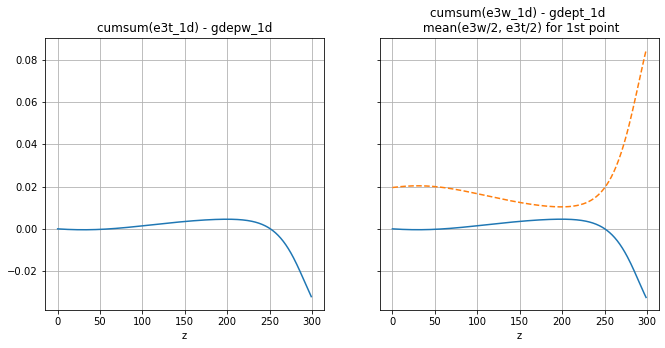

In [9]:
### first of all: compare w depth and cumsum of e3w, 1d fields from grid at rest
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(11,5))

(ds_gro.e3t_1d.cumsum("z").shift(z=1, fill_value=0) - ds_gro.gdepw_1d).plot(ax=axs[0])
axs[0].set_title("cumsum(e3t_1d) - gdepw_1d")

(ds_gro.e3w_1d.cumsum("z") - .75*ds_gro.e3w_1d[0] + .25*ds_gro.e3t_1d[0] - ds_gro.gdept_1d).plot(ax=axs[1])
prov = ds_gro.e3t_1d.cumsum("z")
(.5*(prov.shift(z=1,fill_value=0)+prov) - ds_gro.gdept_1d).plot(ax=axs[1], linestyle="--")
axs[1].set_title("cumsum(e3w_1d) - gdept_1d \n mean(e3w/2, e3t/2) for 1st point")

for ax in axs:
    ax.grid(True)

Bathymetry: compare bathy from file and sum of masked e3t_0

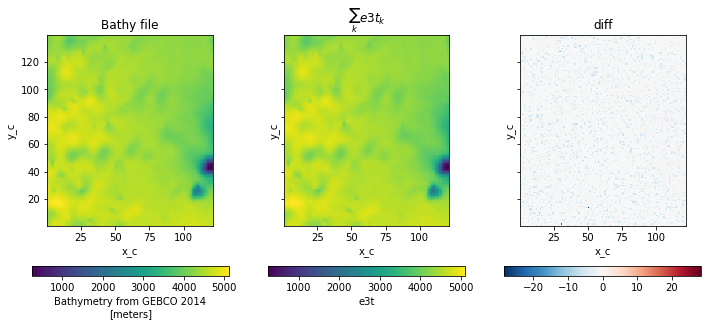

In [10]:
hbot = ds_tot.e3t.where(ds_tot.tmask).sum("z_c")

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,5))
ax = axs[0]
ds_tot.topo.plot(ax=ax, cbar_kwargs={"orientation":"horizontal"})
ax.set_title('Bathy file')
ax = axs[1]
hbot.plot(ax=ax, cbar_kwargs={"orientation":"horizontal"})
ax.set_title(r"$\sum_k e3t_k$")
ax = axs[2]
(hbot - ds_tot.topo).plot(ax=ax, cbar_kwargs={"orientation":"horizontal"})
ax.set_title(r"diff")

for ax in axs:
    ax.set_aspect(1)

Reconstruct ssh from moving z grid (need a topo: test both bathy and sum(e3t): the latter seems to give an accurate result

In [11]:
ssh_hbot = ds_grd.e3t.isel(t=0).where(ds_tot.tmask).sum("z_c")-hbot
ssh_topo = ds_grd.e3t.isel(t=0).where(ds_tot.tmask).sum("z_c")-ds_tot.topo
#ssh_e3t = (ds_grd.e3t.isel(t=0) -  ds_gro.e3t_0.rename({"z":"z_c"})).where(ds_tot.tmask).sum("z_c")

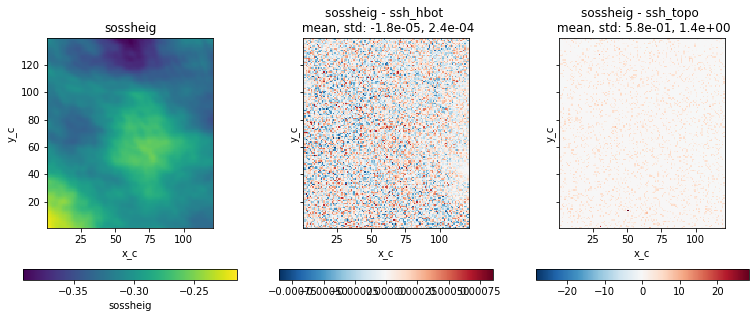

In [12]:

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(13,5))
ax = axs[0]
ds_tot.sossheig.isel(t=0).plot(ax=ax, cbar_kwargs={"orientation":"horizontal"})
ax.set_title('sossheig')
ax = axs[1]
data = ds_tot.sossheig.isel(t=0)-ssh_hbot
data.plot(ax=ax, cbar_kwargs={"orientation":"horizontal"})
ax.set_title('sossheig - ssh_hbot \n mean, std: {:.1e}, {:.1e}'\
             .format(float(data.mean()), float(data.std())))
ax = axs[2]
data = ds_tot.sossheig.isel(t=0)-ssh_topo
data.plot(ax=ax, cbar_kwargs={"orientation":"horizontal"})
ax.set_title('sossheig - ssh_topo \n mean, std: {:.1e}, {:.1e}'\
             .format(float(data.mean()), float(data.std())))
#ax = axs[1,1]
#data = ds_tot.sossheig.isel(t=0)-ssh_e3t
#data.plot(ax=ax)
#ax.set_title('sossheig - ssh_e3t -- mean, std: {:.1e}, {:.1e}'\
#             .format(float(data.mean()), float(data.std())))

for ax in axs.ravel():
    ax.set_aspect(1)

## grid breathing
* Vertical distribution of SSH-induced vertical stretching
* routines and tests for reconstruction / interpolation

In [13]:
ix, jy = 0, 0
it = 0

e3t_t = ds_grd.isel(t=it, x_c=ix, y_c=jy).e3t # moving grid
e3t_0 = ds_gro.e3t_0.rename({"z":"z_c"}).isel(x_c=ix, y_c=jy) # rest grid
sds = ds_tot.isel(t=it, x_c=ix, x_r=ix, y_c=jy, y_r=jy)
sds = sds.assign_coords(hbot=hbot.isel(x_c=ix, y_c=jy)).persist()

In [47]:
isinstance(sds, xr.Dataset)

True

In [94]:
### routine definition
from xorca.orca_names import z_dims
#import xarray as xr

_name = {"et":"e3t", "ew":"e3w", "ssh":"sossheig", "mask":"tmask",
        "zt":"depth_c", "zw":"depth_l"}

def _get_z_dim(data):
    return next(iter(dim for dim in z_dims if dim in data.dims), None)

def _parse_name_dict(dico, special=None):
    if dico is None:
        return _name.copy()
    else:
        newdic = _name.copy()
        if isinstance(dico, dict):
            newdic.update(dico)
        elif isinstance(dico, str):
            newdic[special] = dico
        else:
            raise ValueError('unable to parse "name" argument')
        return newdic
    
def get_hbot(ds, name=None):
    """ compute depth (positive) of bottom, "hbot", from grid metrics (interval) and mask 
    For xorca object, NEMO simulation
    
    Parameters
    __________
    ds: xarray Dataset
        dataset containing grid interval (eg. "e3t") and mask (eg. "tmask"). 
        z dimension is assumed to be "z_c"
    name: dict or str, optional
        name of variables to use in ds. If str, name of grid interval.
        default is {"et":"e3t", "mask":"tmask"}
        
    Returns:
        xarray DataArray names "hbot" containing bottom depth
    """
    
    if "hbot" in ds: # just read variable if already present
        return ds["hbot"]
    else:
        name = _parse_name_dict(name, special="et")
        #if name is None:
        #    name = _name
        #elif not isinstance(name, dict):
        #    nam = _name.copy()
        #    nam["et"] = name
        #    name = nam
        #else:
        #    nam = _name.copy()
        #    nam.update(name)
        #    name = nam.copy()
        et, mask = ds[name["et"]], ds[name["mask"]]
        return et.where(mask).sum("z_c").rename("hbot")

### Vertical grid metrics correction due to varying SSH
def get_del_e3z(ds, which=None, ssh=None, hbot=None, name=None):
    """ compute level thickness (metrics)  perturbation associated with SSH (domvvl) for NEMO grid
    Use either dataset containing all required fields, or DataArray of grid interval
    Grid metric perturbation is simply computed as follows: e3[t,w] * ssh / hbot
    
    Parameters
    __________
    ds: xarray Dataset or DataArray
        contains all fields (vertical grid metrics + ssh + hbot) or just grid metrics
    which: str, optional {"t", "w"}
        which grid level to compute frid perturbation for. 
        Not necessary if ds is the grid metrics DataArray.
    ssh: xarray Datarray, optional
        Sea Surface Height. Not mandatory if present in ds
    hbot: xarray DataArray, optional
        depth of bottom. Not mandatory if present in ds
    name: str or dict, optional
        name of grid metrics or name of the different variables to be used. 

    Returns
    _______
    xarray DataArray of vertical grid metrics perturbation
    
    See also
    ________
    get_rec_e3z, get_del_zlev
    """
    special = "e"+which if which is not None else None
    name = _parse_name_dict(name, special)
    #if name is None:
    #    name = _name
    #elif not isinstance(name, dict):
    #    nam = name
    #else:
    #    nam = _name.copy()
    #    nam.update(name)
    #    name = nam.copy()
    #    if which is not None:
    #        nam = name["e"+which]
        
    nam = ds.name if which is None else name["e"+which]
    
    if ssh is None:
        ssh = ds[name["ssh"]]
    if hbot is None:
        hbot = get_hbot(ds, name=name)
        
    return ds[nam] * ssh / hbot

def get_del_e3t(ds, **kwargs):
    """ get grid metrics perturbation at t-level from xarray Dataset or DataArray 
    See: get_del_e3z """
    return get_del_e3z(ds, which="t", **kwargs)

def get_del_e3w(ds, **kwargs):
    """ get grid metrics perturbation at w-levels from xarray Dataset or DataArray 
    See: get_del_e3z """
    return get_del_e3z(ds, which="w", **kwargs)

def get_rec_e3z(ds, which=None, ssh=None, hbot=None, name=None):
    """ compute perturbated level thickness (metrics) associated with SSH (domvvl) for NEMO grid
    Use either dataset containing all required fields, or DataArray of grid interval
    Perturbated grid metric is simply computed as follows: e3[t,w] * (1. + ssh / hbot)
    
    Parameters
    __________
    ds: xarray Dataset or DataArray
        contains all fields (vertical grid metrics + ssh + hbot) or just grid metrics
    which: str, optional {"t", "w"}
        which grid level to compute frid perturbation for. 
        Not necessary if ds is the grid metrics DataArray.
    ssh: xarray Datarray, optional
        Sea Surface Height. Not mandatory if present in ds
    hbot: xarray DataArray, optional
        depth of bottom. Not mandatory if present in ds
    name: str or dict, optional
        name of grid metrics or name of the different variables to be used. 

    Returns
    _______
    xarray DataArray of vertical grid metrics perturbation
    
    See also
    ________
    get_del_e3z, get_del_zlev
    """
    special = "e"+which if which is not None else None
    name = _parse_name_dict(name, special)
    #if name is None:
    #    name = _name
    #elif not isinstance(name, dict):
    #    nam = name
    #else:
    #    nam = _name.copy()
    #    nam.update(name)
    #    name = nam.copy()
    nam = ds.name if which is None else name[special]

    if ssh is None:
        ssh = ds[name["ssh"]]
    if hbot is None:
        hbot = get_hbot(ds, name=name)
        
    return ds[nam] * (1. + ssh / hbot)
        
def get_rec_e3t(ds, **kwargs):
    """ get perturbated grid metrics at t-level from xarray Dataset or DataArray 
    See: get_rec_e3z """
    return get_rec_e3z(ds, which="t", **kwargs)

def get_rec_e3w(ds, name=None):
    """ get perturbated grid metrics at w-level from xarray Dataset or DataArray 
    See: get_rec_e3z """
    return get_rec_e3z(ds, which="w", **kwargs)

### Vertical grid levels correction due to varying SSH
def get_del_zlev(ds, which=None, ssh=None, hbot=None, name=None):
    """ compute vertical depth perturbation (positive upward) associated with SSH (domvvl) for NEMO grid
    Use either dataset containing all required fields, or DataArray of grid interval
    Level perturbation is simply computed as follows: hab * ssh / hbot, where hab is height above bottom
    
    Parameters
    __________
    ds: xarray Dataset or DataArray
        contains all fields (algebraic z at rest + ssh + hbot) or just z at rest
    which: str, optional {"t", "w"}
        which grid level to compute frid perturbation for. 
        Not necessary if ds is the grid metrics DataArray.
    ssh: xarray Datarray, optional
        Sea Surface Height. Not mandatory if present in ds
    hbot: xarray DataArray, optional
        depth of bottom. Not mandatory if present in ds
    name: str or dict, optional
        name of depth or name of the different variables to be used.

    Returns
    _______
    xarray DataArray of vertical grid level perturbation (positive upward)
    
    See also
    ________
    get_del_e3z, get_rec_e3z, comp_delz_ssh
    """    
    special = ds.name if which is None else "z"+which
    name = _parse_name_dict(name, special)
    nam = ds.name if which is None else name[special]

    #if which is None:
    #    nam = ds.name
    if ssh is None:
        ssh = ds[name["ssh"]]
    if hbot is None:
        hbot = get_hbot(ds, name=name)
    
    return comp_delz_ssh(hbot + ds[nam], ssh, hbot)
        
def get_del_zt(ds, **kwargs):
    """ compute vertical level perturbation at T-levels, due to SSH.
    see: get_del_zlev """
    return get_del_zlev(ds, which="t", **kwargs)
        
def get_del_zw(ds, **kwargs):
    """ compute vertical level perturbation at T-levels, due to SSH.
    see: get_del_zlev """
    return get_del_zlev(ds, which="w", **kwargs)

def comp_delz_ssh(hab0, ssh, hbot):
    """ inputs: height above bottom, ssh, bottom depth (positive)"""

    return hab0*ssh/hbot

### correction of field / interpolation from moving grid to grid at rest
def corr_zbreath(ds, xgrid, hbot=None, ssh=None, which=None, name=None):
    """ correct field to account for moving vertical grid due to SSH. 
    This is equivalent to linearly interpolating data from the moving grid to the grid at rest.
    It is assumed that depth is sorted by increasing depth. 
    Computation goes as follows: f(z_rest) = f(z_vvl) - delta_z * df/dz
    delta_z is computed using get_del_zlev, and df/dz using grid metrics at rest
    
    Parameters
    __________
    ds: xarray Dataset or DataArray
        dataset containing field to interpolate and possibly other data needed for computation
        or DataArray of the field to interpolate only (not working well, still need information 
        on the complementary grid)
    xgrid: xgcm.Grid 
        grid associated with ds. Only the vertical coorinates are important. Metrics are not used.
    hbot: xarray DataArray, optional
        bottom depth (positive). Will be searched for in ds if not passed explicitly
    ssh: xarray DataArray, optional
        Sea Surface Height. Will be searched for in ds if not passed explicitly
    which: str, optional
        name of the variable to interpolate in ds. Mandatory if ds is a DataSet
    name: dict, optional
        dictionary with names of required fieldsfor the computation. Wil use default, _name if not passed
        
    Returns
    _______
    xarra DataArray of interpolated field on the grid at rest
    
    See also
    ________
    get_del_e3z, get_rec_e3z, comp_delz_ssh, get_del_zlev

    
    Todo
    ____
     - implement using metrics from grid object instead of searching for e3t or e3w
    """
    name = _parse_name_dict(name)
    if isinstance(ds, xr.Dataset):
        data = ds[which]
    else:
        data = ds
    zdim = _get_z_dim(data)
    if zdim:
        nam = name["ew"] if zdim=="z_c" else name["et"] # inverted
        which = "t" if zdim=="z_c" else "w"
        e3z = ds[nam]
    else:
        raise ValueError("unable to find vertical dimension")
        
    if hbot is None:
        hbot = get_hbot(ds, name=name)
    if ssh is None:
        ssh = ds[name["ssh"]]
    delz = get_del_zlev(ds, which=which, hbot=hbot, ssh=ssh, name=name)
    dfdz = xgrid.interp(xgrid.diff(data, "Z", boundary="extend")/e3z, "Z", boundary="extend")
    return data + dfdz * delz # NB: dfdz=-dfdz because z sorted by increasing depth


In [75]:
delz = comp_delz_ssh((hbot-ds_gro.gdepw_0.rename({"z":"z_l"})), ds_tot.sossheig.isel(t=0), hbot=hbot)
delw = get_del_zw(ds_tot.isel(t=0))
delw

<xarray.DataArray (y_c: 139, x_c: 121, z_l: 300)>
dask.array<truediv, shape=(139, 121, 300), dtype=float64, chunksize=(139, 121, 2), chunktype=numpy.ndarray>
Coordinates:
  * y_c      (y_c) int64 1 2 3 4 5 6 7 8 9 ... 132 133 134 135 136 137 138 139
  * x_c      (x_c) int64 1 2 3 4 5 6 7 8 9 ... 114 115 116 117 118 119 120 121
    llat_cc  (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    llon_cc  (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    t        datetime64[ns] 2009-07-01T00:30:00
    e1t      (y_c, x_c) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>
    e2t      (y_c, x_c) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>
    topo     (y_c, x_c) float32 4.595e+03 4.604e+03 ... 4.176e+03 4.07e+03
    hbot     (y_c, x_c) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>
  * z_l      (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 295.5 296.5 297.5 298.5 299.5
    depth_l  (z_l) float64 dask.array<chunksize=(2,), meta=np.ndarray>

Text(0.5, 0.98, '$\\delta z$, w-levels')

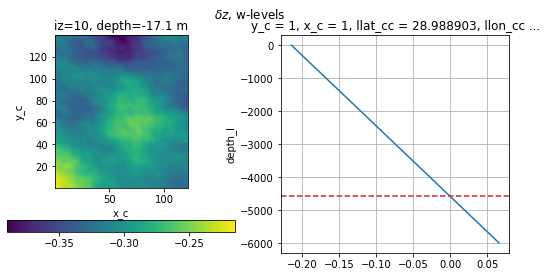

In [41]:
### must cross 0 at -hbot
iz = 10

fig, axs = plt.subplots(1, 2, figsize=(9,4))
delw.isel(z_l=iz).plot(ax=axs[0], cbar_kwargs={"orientation":"horizontal"})
axs[0].set_aspect(1)
axs[0].set_title('iz={0}, depth={1:.1f} m'.format(iz,float(delw.depth_l[iz])))
delw.assign_coords(depth_l=ds_tot.depth_l).isel(x_c=0, y_c=0).plot(ax=axs[1], y="depth_l")
axs[1].axhline(-ds_tot.hbot.isel(x_c=0, y_c=0), linestyle="--", color="tab:red")
axs[1].grid(True)
fig.suptitle(r"$\delta z$, w-levels")

Text(0.5, 0.98, '$\\delta z$, T-levels')

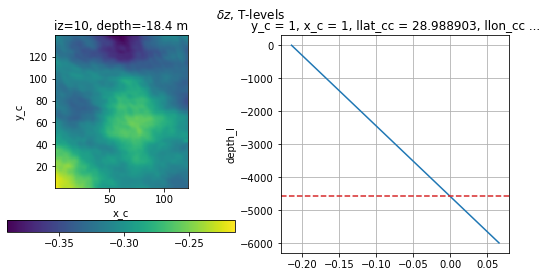

In [38]:
### must cross 0 at -hbot
fig, axs = plt.subplots(1, 2, figsize=(9,4))
delz.isel(z_l=iz).plot(ax=axs[0], cbar_kwargs={"orientation":"horizontal"})
axs[0].set_aspect(1)
axs[0].set_title('iz={0}, depth={1:.1f} m'.format(iz,float(ds_tot.depth_c[iz])))
delz.assign_coords(depth_l=ds_tot.depth_l).isel(x_c=0, y_c=0).plot(ax=axs[1], y="depth_l")
axs[1].axhline(-ds_tot.hbot.isel(x_c=0, y_c=0), linestyle="--", color="tab:red")
axs[1].grid(True)
fig.suptitle(r"$\delta z$, T-levels")

## Work on reconstruction/correction:
* emulate w-grid (from cumsum of e3t)
* evaluate grid reconstruction from SSH correction
* compare spline interpolation and correction using local derivative

Text(0.5, 1.0, 'grid level error')

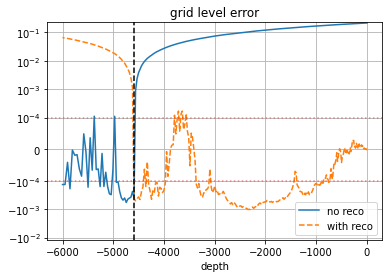

In [67]:
### work on "reconstructed" w levels
z_t = sds.sossheig - grid.cumsum(e3t_t, "Z", boundary="fill", fill_value=0)
z_0 = -grid.cumsum(e3t_0, "Z", boundary="fill", fill_value=0)
delz =  comp_delz_ssh((sds.hbot-ds_gro.gdepw_0.isel(x_c=ix, y_c=jy).rename({"z":"z_l"})), sds.sossheig, hbot=sds.hbot)

### Now plotting: grid levels error
(z_0-z_t).assign_coords(depth=ds_tot.depth_l).plot(x="depth", label="no reco")
(z_0+delz - z_t).assign_coords(depth=ds_tot.depth_l).plot(x="depth", linestyle="--", label="with reco")
plt.legend()

plt.axvline(-sds.hbot.values, linestyle="--", color="k")
lintrh = 1e-4
plt.yscale('symlog', linthresh=lintrh)
plt.axhline(lintrh, linestyle=":", color="tab:red", alpha=.5)
plt.axhline(-lintrh, linestyle=":", color="tab:red", alpha=.5)
plt.grid(True)
plt.title('grid level error')

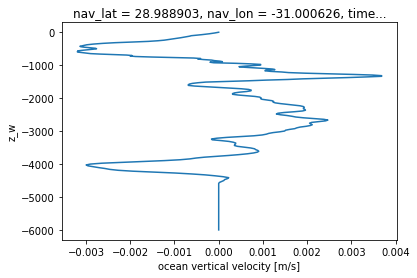

In [96]:
### test interpolation -> load a fake w velocity profile
daw = xr.open_dataset(data_path/"eNATL60NOE-BLBT02_y2010m01d01.1h_vovecrtz_0-botm.nc").vovecrtz\
        .isel(time_counter=0, x=ix, y=jy)
daw = daw.assign_coords(z_l=.5+0*daw.depthw+np.arange(daw.depthw.size)).swap_dims({"depthw":"z_l"})
daw = daw.assign_coords(z_w = z_t)
daw.plot(y="z_w")

sds = sds.merge(daw)


In [102]:
delz

<xarray.DataArray (y_c: 139, x_c: 121, z_l: 300)>
dask.array<truediv, shape=(139, 121, 300), dtype=float64, chunksize=(139, 121, 300), chunktype=numpy.ndarray>
Coordinates:
  * y_c      (y_c) int64 1 2 3 4 5 6 7 8 9 ... 132 133 134 135 136 137 138 139
  * x_c      (x_c) int64 1 2 3 4 5 6 7 8 9 ... 114 115 116 117 118 119 120 121
    llat_cc  (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    llon_cc  (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    e1t      (y_c, x_c) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>
    e2t      (y_c, x_c) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>
    topo     (y_c, x_c) float32 4.595e+03 4.604e+03 ... 4.176e+03 4.07e+03
    hbot     (y_c, x_c) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>
    t        datetime64[ns] 2009-07-01T00:30:00
Dimensions without coordinates: z_l

Text(0.75, 0.1, 'STD: 1.49e-03')

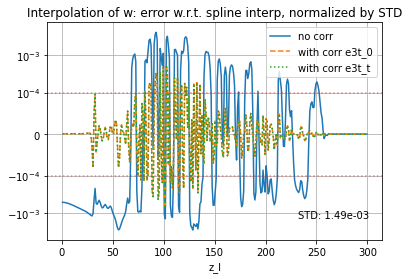

In [103]:
### interpolation vs. reconstruction

# interpolate using cubic spline. Serve as reference
w_interp = daw.drop("z_l").swap_dims({"z_l":"z_w"}).interp(z_w=z_0, method="cubic", 
                                               kwargs={"fill_value":"extrapolate"})
# reconstruct using -delz*f'(z) (f' is -grid.diff, because z goes downward)
w_reco = corr_zbreath(sds, grid, which="vovecrtz")
# same but using reconstructed e3t instead of e3t_0. Changes are not visible
prov = rec_e3(sds.e3t, sds.sossheig, hbot=sds.hbot)
delz = get_del_zw(sds)
w_recb = daw + grid.interp(grid.diff(daw, "Z", boundary="extend")/prov, "Z", boundary="extend") * delz

### Now plotting
plt.figure()
((daw-w_interp)/daw.std()).plot(label="no corr")
((w_reco-w_interp)/daw.std()).plot(linestyle="--", label="with corr e3t_0")
((w_recb-w_interp)/daw.std()).plot(linestyle=":", label="with corr e3t_t")
plt.grid(True)
plt.legend()
lintrh = 1e-4
plt.yscale('symlog', linthresh=lintrh)
plt.axhline(lintrh, linestyle=":", color="tab:red", alpha=.5)
plt.axhline(-lintrh, linestyle=":", color="tab:red", alpha=.5)
plt.title("Interpolation of w: error w.r.t. spline interp, normalized by STD")
plt.text(.75, .1, "STD: {:.2e}".format(float(daw.std())), transform=plt.gca().transAxes)